In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [2]:
import albumentations as A
import mermaidseg.datasets.dataset
import numpy as np
from mermaidseg.io import setup_config, get_parser, update_config_with_args
import copy
import torch
from matplotlib import pyplot as plt

In [3]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True

CUDA Device 0: Tesla T4


In [ ]:
from torch.utils.data import DataLoader, random_split
from mermaidseg.model.meta import MetaModel
from mermaidseg.model.eval import EvaluatorSemanticSegmentation
from mermaidseg.logger import Logger
from mermaidseg.model.train import train_model

## Config

In [6]:
# Start off with a configuration file
cfg = setup_config(config_path='../configs/linear-dinov2-base.yaml', config_base_path='../configs/concept_mermaid.yaml')

# Update the initial configuration file with command line arguments 
# (in the case of a notebook run these can be defined explicitly here)
args_input = "--run-name=notebook_test_run --batch-size=4 --epochs=5 --log-epochs=1"
args_input = args_input.split(" ")

parser = get_parser()
args = parser.parse_args(args_input)

cfg = update_config_with_args(cfg, args)
cfg_logger = copy.deepcopy(cfg)

# 2. Data

In [7]:
transforms = {}
for split in cfg.augmentation:
    transforms[split] = A.Compose(
        [
            getattr(A, transform_name)(**transform_params) for transform_name, transform_params
                                                                 in cfg.augmentation[split].items()
        ]
    )

In [8]:
dataset_name = cfg.data.pop("name", None)
batch_size = cfg.data.pop("batch_size", 8)
dataset = getattr(mermaidseg.datasets.dataset, dataset_name)(transform = transforms["train"], **cfg.data)

In [9]:
len(dataset)

7542

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


(3, 518, 518) (518, 518)


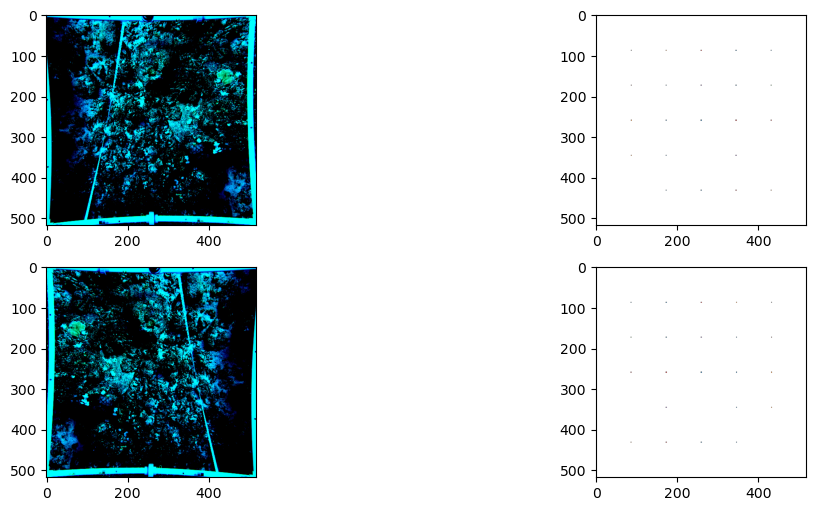

In [10]:
fig, ax = plt.subplots(figsize= (13,6), ncols = 2, nrows = 2)

image, mask, annotations = dataset[0]
print(image.shape, mask.shape)

ax[0, 0].imshow(image.transpose(1,2,0))
ax[0, 1].imshow(np.where(mask>0, mask, np.nan), cmap = "tab10", vmin=1, vmax=15)

image, mask, annotations = dataset[0]

ax[1, 0].imshow(image.transpose(1,2,0))
ax[1, 1].imshow(np.where(mask>0, mask, np.nan), cmap = "tab10", vmin=1, vmax=15)

plt.show()

In [11]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
train_dataset = torch.utils.data.Subset(train_dataset, range(200))
val_dataset = torch.utils.data.Subset(val_dataset, range(100))
test_dataset = torch.utils.data.Subset(test_dataset, range(100))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)

In [12]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 50
Number of validation batches: 25
Number of test batches: 25


In [13]:
dataset.num_classes, dataset.num_concepts

(16, 20)

# 3. Model

In [14]:
meta_model = MetaModel(run_name = cfg.run_name, 
                       num_classes = dataset.num_classes,
                       device = device,
                       model_kwargs = cfg.model,
                       training_kwargs = cfg.training)

In [15]:
evaluator = EvaluatorSemanticSegmentation(num_classes=dataset.num_classes,
                                            device=device,
                                            )

In [16]:
from mermaidseg.logger import Logger

logger = Logger(
    config = cfg_logger,
    meta_model = meta_model,
    log_epochs = cfg.logger.log_epochs,
    log_checkpoint = 2, #cfg.logger.log_checkpoint
    checkpoint_dir = ".",
    mlflow = False
)

In [ ]:
from mermaidseg.model.train import train_model
train_model(meta_model, evaluator, train_loader, val_loader, logger=logger)

EPOCH: 0


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


LOSS train 2.3034382247924805


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


LOSS valid 2.2619038248062133


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


train metrics
{'accuracy': 0.33127638697624207, 'mean_iou': 0.03772212937474251}


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


validation metrics
{'accuracy': 0.2600453197956085, 'mean_iou': 0.029206901788711548}
EPOCH: 1


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


LOSS train 2.0634396719932555


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


LOSS valid 2.202225322723389


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


train metrics
{'accuracy': 0.30214861035346985, 'mean_iou': 0.022582128643989563}


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


validation metrics
{'accuracy': 0.27728551626205444, 'mean_iou': 0.0205958504229784}
EPOCH: 2


100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


LOSS train 2.0488675141334536


100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


LOSS valid 2.1270958375930786


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


train metrics
{'accuracy': 0.35858166217803955, 'mean_iou': 0.039549995213747025}


100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


validation metrics
{'accuracy': 0.31739816069602966, 'mean_iou': 0.03623225912451744}
EPOCH: 3


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


LOSS train 2.040419511795044


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


LOSS valid 2.155509867668152


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


train metrics
{'accuracy': 0.3758792579174042, 'mean_iou': 0.04189550131559372}


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


validation metrics
{'accuracy': 0.32873135805130005, 'mean_iou': 0.03719691187143326}
EPOCH: 4


 24%|██▍       | 12/50 [00:16<00:45,  1.21s/it]